In [276]:
import pandas as pd
import scipy.stats as st
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

In [277]:
dataset1 = pd.read_csv("dataset1.csv")
dataset2 = pd.read_csv("dataset2.csv")
dataset1.head()

,start_time,bat_landing_to_food,habit,rat_period_start,rat_period_end,seconds_after_rat_arrival,risk,reward,month,sunset_time,hours_after_sunset,season
0,30/12/2017 18:37,16.000000,rat,30/12/2017 18:35,30/12/2017 18:38,108,1,0,0,30/12/2017 16:45,1.870833,0
1,30/12/2017 19:51,0.074016,fast,30/12/2017 19:50,30/12/2017 19:55,17,0,1,0,30/12/2017 16:45,3.100833,0
2,30/12/2017 19:51,4.000000,fast,30/12/2017 19:50,30/12/2017 19:55,41,0,1,0,30/12/2017 16:45,3.107500,0
3,30/12/2017 19:52,10.000000,rat,30/12/2017 19:50,30/12/2017 19:55,111,1,0,0,30/12/2017 16:45,3.126944,0
4,30/12/2017 19:54,15.000000,rat,30/12/2017 19:50,30/12/2017 19:55,194,1,0,0,30/12/2017 16:45,3.150000,0


In [278]:
dataset2.head()

,time,month,hours_after_sunset,bat_landing_number,food_availability,rat_minutes,rat_arrival_number
0,26/12/2017 16:13,0,-0.5,20,4.000000,0.0,0
1,26/12/2017 16:43,0,0.0,28,4.000000,0.0,0
2,26/12/2017 17:13,0,0.5,25,4.000000,0.0,0
3,26/12/2017 17:43,0,1.0,71,4.000000,0.0,0
4,26/12/2017 18:13,0,1.5,44,3.753857,0.0,0


In [ ]:
refined_dataset2 = dataset2.copy()
refined_dataset2["obs_start_time"] = pd.to_datetime(refined_dataset2["time"], format="%d/%m/%Y %H:%M")
refined_dataset2.drop(columns=["time"], inplace=True) # we have obs_start_time
refined_dataset2["obs_end_time"] = refined_dataset2["obs_start_time"] + pd.to_timedelta(30, unit="m")
# track observation number
refined_dataset2 = refined_dataset2.reset_index().rename(columns={"index": "obs_num"})
refined_dataset2["obs_num"] += 1

refined_dataset1 = dataset1[["start_time", "rat_period_start", "rat_period_end", "risk", "reward", "seconds_after_rat_arrival", "bat_landing_to_food"]].copy()
refined_dataset1["start_time"] = pd.to_datetime(refined_dataset1["start_time"], format="%d/%m/%Y %H:%M")
refined_dataset1["rat_period_start"] = pd.to_datetime(refined_dataset1["rat_period_start"], format="%d/%m/%Y %H:%M")
refined_dataset1["rat_period_end"] = pd.to_datetime(refined_dataset1["rat_period_end"], format="%d/%m/%Y %H:%M")

# calculated end time of bat
refined_dataset1["end_time"] = refined_dataset1["start_time"] + pd.to_timedelta(refined_dataset1["bat_landing_to_food"], unit="s")


# calculated the time between rat landing and bat goes to food
refined_dataset1["rat_landing_to_bat_food"] = refined_dataset1["seconds_after_rat_arrival"] + refined_dataset1["bat_landing_to_food"]
refined_dataset1["rat_stay"] = (refined_dataset1["rat_period_end"] - refined_dataset1["rat_period_start"]).dt.total_seconds()

Count of positive rewards 484
Count of negative rewards 423
Count of positive risks 449
Count of negative rewards 458


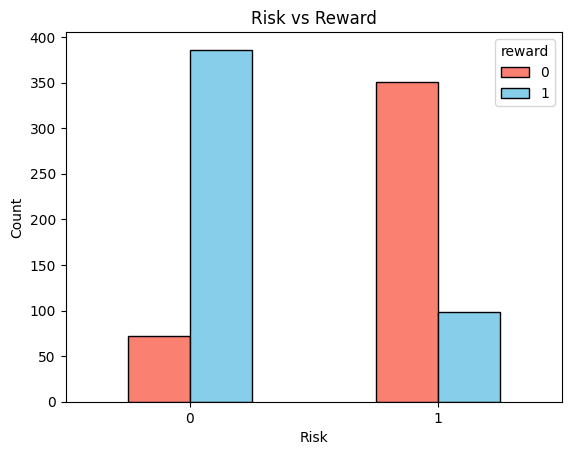

In [289]:
# To check how rewarding it is when taken risk
def risk_vs_reward_show(dataset):
    print("Count of positive rewards", dataset[dataset["reward"] == 1].shape[0])
    print("Count of negative rewards", dataset[dataset["reward"] == 0].shape[0])
    print("Count of positive risks", dataset[dataset["risk"] == 1].shape[0])
    print("Count of negative rewards", dataset[dataset["risk"] == 0].shape[0])

    # Count of risks vs rewards
    counts = dataset.groupby(["risk", "reward"]).size().unstack(fill_value=0)    
    counts.plot(kind="bar", color=["salmon", "skyblue"], edgecolor="black", title="Risk vs Reward")
    plt.ylabel("Count")
    plt.xlabel("Risk")
    plt.xticks(rotation=0)
    plt.show()

risk_vs_reward_show(refined_dataset1)

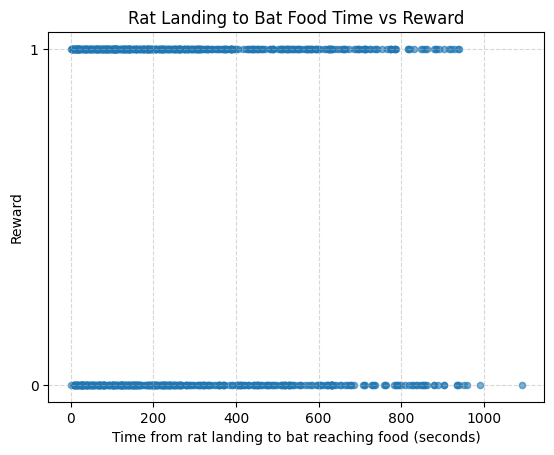

In [303]:
# To see the relationship between time taken from rat landing to bat reaching food and reward
refined_dataset1.plot.scatter(
    x="rat_landing_to_bat_food",
    y="reward",
    alpha=0.6,
    title="Rat Landing to Bat Food Time vs Reward"
)

plt.xlabel("Time from rat landing to bat reaching food (seconds)")
plt.ylabel("Reward")
plt.yticks([0,1])
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [291]:
# merge datasets
combined_dataset = refined_dataset1.assign(key=1).merge(
    refined_dataset2.assign(key=1), on="key", suffixes=("_event", "_obs")
).drop("key", axis=1)

# Keep only overlapping intervals
combined_dataset = combined_dataset[
    (combined_dataset["start_time"] <= combined_dataset["obs_end_time"]) &
    (combined_dataset["start_time"] >= combined_dataset["obs_start_time"])
]

combined_dataset.sort_values(by="obs_num", ascending=True)
combined_dataset.head()

,start_time,rat_period_start,rat_period_end,risk,reward,seconds_after_rat_arrival,bat_landing_to_food,end_time,rat_presence,rat_landing_to_bat_food,rat_stay,obs_num,month,hours_after_sunset,bat_landing_number,food_availability,rat_minutes,rat_arrival_number,obs_start_time,obs_end_time
115,2017-12-30 18:37:00,2017-12-30 18:35:00,2017-12-30 18:38:00,1,0,108,16.000000,2017-12-30 18:37:16.000000000,1,124.000000,180.0,116,0,1.5,36,4.000000,3.283333,1,2017-12-30 18:15:00,2017-12-30 18:45:00
2241,2017-12-30 19:51:00,2017-12-30 19:50:00,2017-12-30 19:55:00,0,1,17,0.074016,2017-12-30 19:51:00.074015603,1,17.074016,300.0,119,0,3.0,37,3.067912,5.000000,1,2017-12-30 19:45:00,2017-12-30 20:15:00
4364,2017-12-30 19:51:00,2017-12-30 19:50:00,2017-12-30 19:55:00,0,1,41,4.000000,2017-12-30 19:51:04.000000000,1,45.000000,300.0,119,0,3.0,37,3.067912,5.000000,1,2017-12-30 19:45:00,2017-12-30 20:15:00
6487,2017-12-30 19:52:00,2017-12-30 19:50:00,2017-12-30 19:55:00,1,0,111,10.000000,2017-12-30 19:52:10.000000000,1,121.000000,300.0,119,0,3.0,37,3.067912,5.000000,1,2017-12-30 19:45:00,2017-12-30 20:15:00
8610,2017-12-30 19:54:00,2017-12-30 19:50:00,2017-12-30 19:55:00,1,0,194,15.000000,2017-12-30 19:54:15.000000000,1,209.000000,300.0,119,0,3.0,37,3.067912,5.000000,1,2017-12-30 19:45:00,2017-12-30 20:15:00


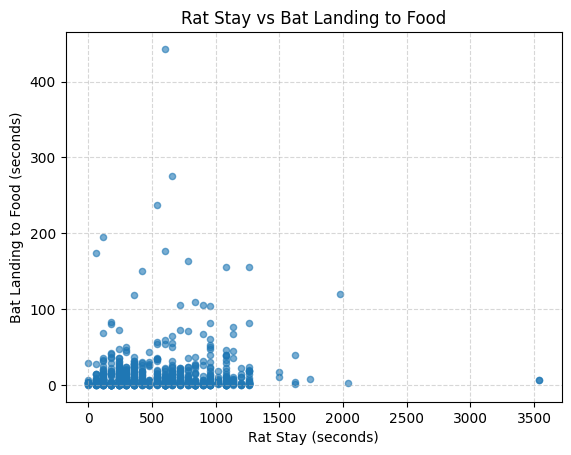

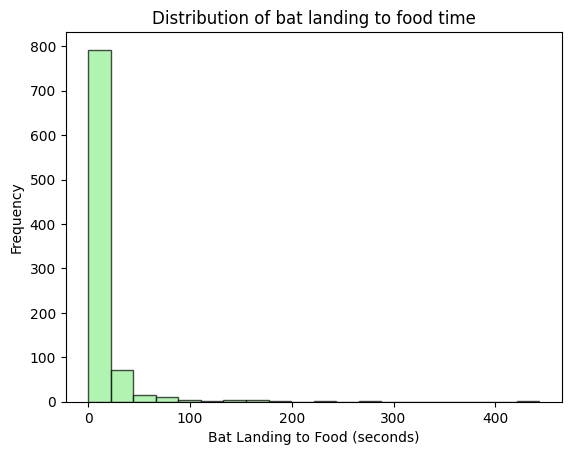

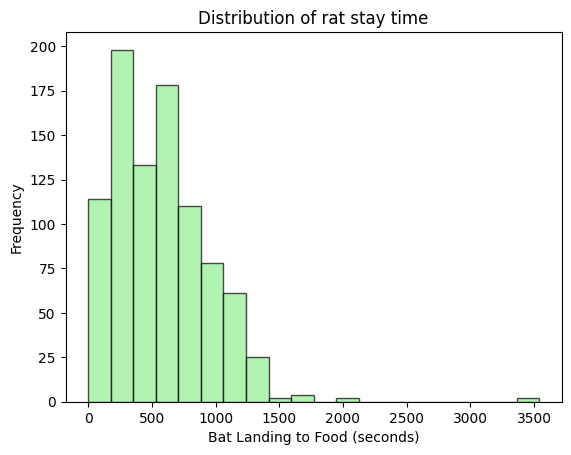

In [321]:
# Compare how the bat landing to food time with the rat stay duration
refined_dataset1.plot.scatter(
    x="rat_stay",
    y="bat_landing_to_food",
    alpha=0.6,
    title="Rat Stay vs Bat Landing to Food"
)
plt.xlabel("Rat Stay (seconds)")
plt.ylabel("Bat Landing to Food (seconds)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

refined_dataset1["bat_landing_to_food"].plot(
    kind="hist",
    bins=20,
    color="lightgreen",
    edgecolor="black",
    alpha=0.7,
    title="Distribution of bat landing to food time"
)
plt.xlabel("Bat Landing to Food (seconds)")
plt.show()

refined_dataset1["rat_stay"].plot(
    kind="hist",
    bins=20,
    color="lightgreen",
    edgecolor="black",
    alpha=0.7,
    title="Distribution of rat stay time"
)
plt.xlabel("Bat Landing to Food (seconds)")
plt.show()

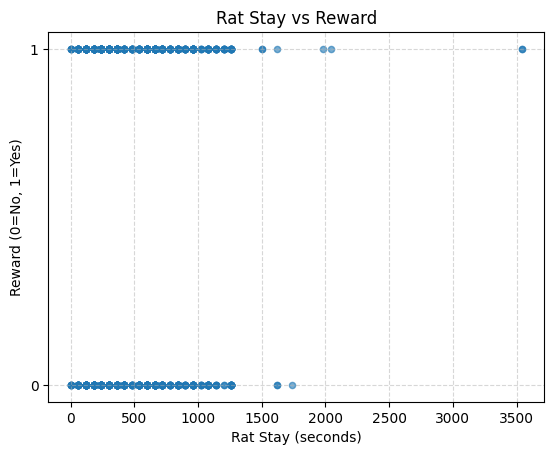

In [299]:
# 1. Scatter plot: rat_stay vs reward
refined_dataset1.plot.scatter(
    x="rat_stay",
    y="reward",
    alpha=0.6,
    title="Rat Stay vs Reward"
)
plt.xlabel("Rat Stay (seconds)")
plt.ylabel("Reward (0=No, 1=Yes)")
plt.yticks([0, 1])
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()